# Inverted Pendulum
***
My goal for this project is to explore estimation, control, and measurement of an inverted pendulum on a cart. This notebook is broken up into three parts.

1. **Kinematics**
2. **Control**
3. **State estimation with a Kalman filter**

The basis setup is we have a cart of mass $M$ and mass at the top of a pole on the cart of mass $m$. We will assume the pole itself to be massless. 

Let $\theta$ represent the angle between vertical and the pole, let $v_1$ represent the velocity of the cart and $v_2$ the velocity of the mass on the pole. Let $F$ be the force exerted on the cart (which we constrain to move along the x-axis) and the pole will be of length $l$. 

<img src="inverted_pendulum_graphic.jpg" width="400"/>

## 1. Kinematics

Let's start by calculating the kinematics of the system. By the [principal of least action](https://www.feynmanlectures.caltech.edu/II_19.html) the path of the pole mass and the car minimizes the functional 

$$
J[x, \theta] = \int_{t_0}^{t_1} L 
$$

Where $L$ is the Lagrangian $L = T - U$ which represents the difference in kinetic and potential energy of the system. The position of the cart at time $t$ is $(x(t), 0)$ and the position of the pole mass is $(x + l \sin{\theta}, l\cos{\theta})$. We can express the kinetic energy of the system as: 

$$ 
\begin{aligned}
T &= \frac{1}{2}M v_1^2 + \frac{1}{2} m v_2^2 \\

T &= \frac{1}{2}(M) \dot{x}^2 + \frac{1}{2}m((\dot{x} + l \dot{\theta} \cos{\theta})^2 + (-l\dot{\theta} \sin{\theta})^2) \\

T &= \frac{1}{2} (m + M) \dot{x}^2 + \frac{1}{2} m l^2 \dot{\theta}^2 - m l \dot{\theta} \dot{x} \cos{theta}

\end{aligned}
$$

And the potential energy can be expressed simply: 

$$
\begin{aligned}
U &= m g l \cos{\theta} \\
\end{aligned}
$$

### 1.1 Apply the principle of least action to calculate the differential equations
By applying [D'Alambert's principle](https://en.wikipedia.org/wiki/D%27Alembert%27s_principle#:~:text=D'Alembert's%20principle%20generalizes%20the,system%2C%20result%20in%20dynamic%20equilibrium.&text=D'Alembert's%20principle%20can%20be,constraints%20that%20depend%20on%20velocities.), the euler-lagrange equations now include the non-conservative force F. 


$$
\begin{aligned}
\frac{\partial L}{\partial x} - \frac{d}{dt} \frac{\partial L}{\partial \dot{x}} &= F \\

\frac{\partial L }{\partial \theta} -  \frac{d}{dt}  \frac{\partial L}{\partial \dot{\theta}} &= 0
\end{aligned}
$$

To review the derivation of the Euler-lagrange equations from the principle of least action I found a [good video](https://www.youtube.com/watch?v=sFqp2lCEvwM). Based on the equations for kinetic and potential energy above, we can now calculate all the relevant partial derivatives. 

$$
\begin{aligned}
\frac{\partial L}{\partial x} &= 0 \\

\frac{\partial L}{\partial \dot{x}} &= (M + m) \dot{x} + ml \dot{\theta} \cos{\theta} \\

\frac{\partial L}{\partial \theta} &=  - m l \dot{x} \theta \sin{\theta} + m g l \sin(\theta) = m l \sin{\theta} (g - \dot{x} \theta) \\

\frac{\partial L}{\partial \dot{\theta}} &= m l^2 \dot{\theta} + m l \dot{x} \cos{\theta} \\

\end{aligned}
$$

Now plugging those partials into the euler-lagrange equations we ultimately get: 

$$
\begin{aligned}
- (M + m) \ddot{x} - m l \ddot{\theta} \cos{\theta} + m l \dot{\theta}^2 \sin{\theta} &= F \\
g \sin{\theta} - l \ddot{\theta} - \ddot{x} \cos{\theta} &= 0

\end{aligned}
$$

We can manipulate the above equations to solve for $\ddot{\theta}$ and $\ddot{x}$. Doing that we get 

$$
\begin{aligned}
\ddot{x} &= \frac{-F - mg \cos{\theta} \sin{\theta} + ml \dot{\theta}^2 \sin{\theta}}{M + m \sin^2{\theta}} \\

\ddot{\theta} &= \frac{F \cos{\theta} - m l \theta^2 \sin{\theta} \cos{\theta} + (M + m) g \sin{\theta}}{Ml + ml \sin^2{\theta}}
\end{aligned}
$$

### 1.2 Linearization of the problem
To simply the problem further, we make the assumption of small angles and therefore are able to linearize the above equations around $\theta=0$. 

$$
\begin{aligned}
-(M + m) \ddot{x} - ml \ddot{\theta} &= F \\
g \theta - l \ddot{\theta} - \ddot{x} = 0
\end{aligned}
$$

With minimal algebraic manipulation we can rewrite these equations as:

$$
\begin{aligned}
\ddot{x} &= - \frac{F}{M} - \frac{mg\theta}{M} \\

\ddot{\theta} &= \frac{mg}{Ml} \theta + \frac{g}{l} \theta + \frac{F}{Ml}
\end{aligned}
$$

We can now write everything out as four first order first-order differential equations. 

### 1.3 Write in matrix form

We will define our state vector like so
$$
\mathbf{x} = \begin{bmatrix} x_1 \ x_2 \ x_3 \ x_4 \end{bmatrix} = \begin{bmatrix} x \ \dot{x} \ \theta \ \dot{\theta} \end{bmatrix} \\
$$

We will define our input vector as 
$$
\mathbf{u} = \begin{bmatrix} F \end{bmatrix}
$$

The first order system of differential equations can then be expressed in matrix form:
$$
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}
$$

Where A is defined like so: 
$$
\mathbf{A} = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & - \frac{mg}{M} & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & \frac{mg}{Ml} + \frac{g}{l} & 0 \end{bmatrix}
$$

and B is defined like so
$$
\mathbf{B} = \begin{bmatrix} 0 \ - \frac{1}{M} \ 0 \ \frac{1}{Ml} \end{bmatrix}
$$

### 1.4 Code

Now that we have a mathmatical understanding of the problem, let's write out some functions to return the matrix $A$ and $B$ from above, a function to solve for $X$ and $U$ given a matrix with constants of proportional control $K$, and a couple functions to plot the state of the system over time. 

Note, for our truth model we use the full non-linear differential equations. 

In [12]:
import numpy as np
import scipy

def get_matrices_A_B(M, m, g, l):
    """
    Returns the system matrix A and input matrix B.

    Parameters:
    M (float): Mass of the cart.
    m (float): Mass of the pendulum.
    g (float, optional): Acceleration due to gravity. 
    l (float, optional): Length of the pendulum.

    Returns:
    A (numpy.ndarray): System matrix.
    B (numpy.ndarray): Input matrix.
    """

    A = np.array([
        [0, 1, 0, 0],
        [0, 0, -(m * g) / M, 0],
        [0, 0, 0, 1],
        [0, 0, (m * g) / (M * l) + g / l, 0]
    ])

    B = np.array([
        [0],
        [-1 / M],
        [0],
        [1 / (M * l)]
    ])

    return A, B


In [13]:
def u_func(x, K):
    """
    Proportional control.

    Parameters:
    x (numpy.ndarray): state vector (4, )
    K (numpy.ndarray): Proportional control matrix (1, 4)

    Returns: 
    u (numpy.ndarray): control input (1, )
    """
    return - K @ x

def dxdt_wrapper(x, _, K):
    """Wrapper for dxdt_nonlinear functions with different parameters."""
    
    return dxdt_nonlinear(x, _, u_func(x, K))

def dxdt_linear(x, _, u, omega=np.zeros(4)):
    """
    Returns the state vector derivatives, using a linearized system.

    Parameters:
    x (numpy.ndarray): state vector (4, )
    u (numpy.ndarray): control input (1, )
    omega (numpy.ndarray): gaussian noise (4, )

    Returns:
    dxdt (numpy.ndarray): state vector derivatives (4, )
    """
    dxdt = A @ x.reshape(4,1) + B @ u.reshape((1,1)) + omega.reshape(4,1)

    return dxdt.reshape(4)

def dxdt_nonlinear(x, _, u, omega=np.zeros(4)):
    """
    Function that defines the non-linear first order differential equations 
    for the inverted pendulum. 

    Parameters:
    ----------
    x (numpy.ndarray): state vector (4, )
    u (numpy.ndarray): control input (1, )
    omega (numpy.ndarray): gaussian noise (4, )

    Returns:
    --------
    dxdt (numpy.ndarray): full state derivate vector (4, )

    """
    
    theta = x[2]
    global g, m, l, M
    force = u[0]

    dxdt = np.zeros(4)

    dxdt[0] = x[1]
    dxdt[1] = (-force - m*g*np.cos(theta)*np.sin(theta) + m * l * x[3]**2 * np.sin(theta)) / (M + m * np.sin(theta)**2)
    dxdt[2] = x[3]
    dxdt[3] = (force*np.cos(theta) - m * l * theta**2 * np.sin(theta) * np.cos(theta) + (M + m) *g *np.sin(theta)) / (M*l + m*l*np.sin(theta)**2)

    # gaussian noise
    dxdt += omega.flatten()

    return np.resize(dxdt, 4)

def solve_cart_control(t, X0, K, dxdt):
    """
    Given an initial condition, solve the control problem at each time step. 

    Parameters: 
    -----------
    t (numpy.ndarray): time values with shape (n+1, )
    X0 (numpy.ndarray): Initial conditions on state variables (4,1)
    K (numpy.ndarray): Proportional control matrix (1, 4).
    dxdt (function): full state derivative function. 

    Returns
    -------
    X (numpy.ndarray): the state vector at each time (n+1, 4). 
    U (numpy.ndarray): the control values (n+1, 1). 

    """

    X = scipy.integrate.odeint(dxdt_wrapper, np.resize(X0, 4), t, (K,  ))
    U = (K @ X.T).T

    return X, U 

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import HTML
from matplotlib import animation

def plot_state_vector_vs_time(t, X):
    """
    Simple function to plot x, x_dot, theta, theta_dot against time. 
    """

    plt.plot(t, X[:,0], label="x")
    plt.plot(t, X[:,1], label="x dot")
    plt.plot(t, X[:,2], label="theta")
    plt.plot(t, X[:,3], label="theta dot")


    plt.title('State variables vs time')
    plt.legend()
    plt.xlabel("t [s]")

    plt.show()

def plot_input_vs_time(t, U):
    """
    Simple function to plot F against time.
    """

    plt.plot(t, U[:,0], label="Applied force")

    plt.title("Applied force vs time")
    plt.legend()
    plt.xlabel("t [s]")

    plt.show()


def animate_cart_and_pendulum(t, X):
    """
    Animate the position of the cart and the inverse pendulum based on the passed in state matrix and time vector. 
    """

    fig = plt.figure(figsize=(8,6.4))
    ax = fig.add_subplot(111,autoscale_on=False,\
                        xlim=(-1.5,5),ylim=(-0.4,5))
    ax.set_xlabel('position')
    ax.get_yaxis().set_visible(False)

    start, = ax.plot([-1,-1],[-1.5, 5],'k:',lw=2)
    objective, = ax.plot([0,0],[-0.5, 5],'k:',lw=2)

    mass1, = ax.plot([],[],linestyle='None',marker='s',\
                    markersize=40,markeredgecolor='k',\
                    color='blue',markeredgewidth=2)
    mass2, = ax.plot([],[],linestyle='None',marker='o',\
                    markersize=20,markeredgecolor='k',\
                    color='blue',markeredgewidth=2)
    line, = ax.plot([],[],'o-',color='blue',lw=4,\
                    markersize=6,markeredgecolor='k',\
                    markerfacecolor='k')

    time_template = 'time = %.1f [s]'
    time_text = ax.text(0.7,0.9,'',transform=ax.transAxes)

    theta_template = 'theta = %.4f [rad]'
    theta_text = ax.text(0.7,0.86,'',transform=ax.transAxes)

    def init():
        mass1.set_data([],[])
        mass2.set_data([],[])
        line.set_data([],[])
        time_text.set_text('')
        theta_text.set_text('')
        return line, mass1, mass2, time_text, theta_text

    def animate(i):
        theta = X[i,2]
        x1, y1 = X[i,0], -0.1
        x2, y2 = x1 + l*np.sin(theta), l*np.cos(theta)
        mass1.set_data([x1],[y1])
        mass2.set_data([x2],[y2])
        line.set_data([x1,x2],[y1,y2])
                    
        time_text.set_text(time_template % t[i])
        theta_text.set_text(theta_template % theta)

        return line, mass1, mass2, time_text, theta_text
    
    # Avoid showing the plt twice.
    plt.close()

    return animation.FuncAnimation(fig, animate, \
            np.arange(len(t)), \
            blit=False,init_func=init)

### 1.5 Sanity check 
First, as a quick sanity check  of our kinematics lets simulate a pendulum absent any external force. We will set initial conditions here that we will continue to use for the rest of our experiments. 

In [23]:
# Set initial conditions
M, m = 17, 2
l = 4
g = 9.8

# Get the linearized equations for the state vector and force vector.
A, B = get_matrices_A_B(M, m, g, l)

# Let's set the proportional control matrix equal to zero. 
Kr = np.zeros((1, 4))

X0 = np.array([-1, 0, 0.1, 0])
t = np.linspace(0, 15, 75)

X, U = solve_cart_control(t, X0, Kr, dxdt_wrapper)

HTML(animate_cart_and_pendulum(t, X).to_html5_video())

## 2. Control
Alright, that sanity check looks reasonable. The pendulum accelerates downwards on the right hand side of the cart, forcing the card to slide to the left.

One logical question to ask is whether our system of an inverted pendulum is controllable. That is to say: is any state $\xi \in \R^4$ reachable in finite time?

 To understand how to think about this question I consulted a [pdf](https://databookuw.com/databook.pdf) of the textbook [Data-driven science and engineering](https://databookuw.com/). From that I was reminded that the controllability of a linear system is entirely determined by the column space of the matrix:

$$
\begin{equation}
C = \begin{bmatrix} B & AB & A^2 B & A^3 B \end{bmatrix}
\end{equation}
$$

In the case that the controllability matrix has full rank, then it is possible to design arbitrary eigenvalues for the closed loop system through the definition of K, the constants of proportional control. 

$$
\dot{x} = (A - BK)x
$$

Because we can define the eigenvalues of the matrix $A - BK$ we can therefore create a stable system by selecting all negative eigenvalues. 


In [24]:
import control 

rank = np.linalg.matrix_rank(control.ctrb(A, B))
print(f"The rank of the controllability matrix is: {rank}")

The rank of the controllability matrix is: 4


Now that we have shown the system is controlable and that we can set arbitrary eigenvalues for the matrix $A - BK$, lets pick a K such that $A - BK$ has entirely negative eigenvalues. That K should result in a stable control model for the inverted pendulum. 

In [25]:
# Set four arbitrary negative eigenvalues 
eigs = [-1, -1.1, -1.2, -1.3]

Kr = control.place(A, B, eigs)

print(f"Eigenvalues of A - BK: {np.linalg.eig(A - B @ Kr)[0]}")

Eigenvalues of A - BK: [-1.3 -1.  -1.2 -1.1]


With only the $K$ matrix modified, let's re-run the previous simulation. 

In [26]:
X, U = solve_cart_control(t, X0, Kr, dxdt_wrapper)

HTML(animate_cart_and_pendulum(t, X).to_html5_video())

Great! Looks like we indeed found a stable solution. For further clarity, lets plot the state vectors against time. 

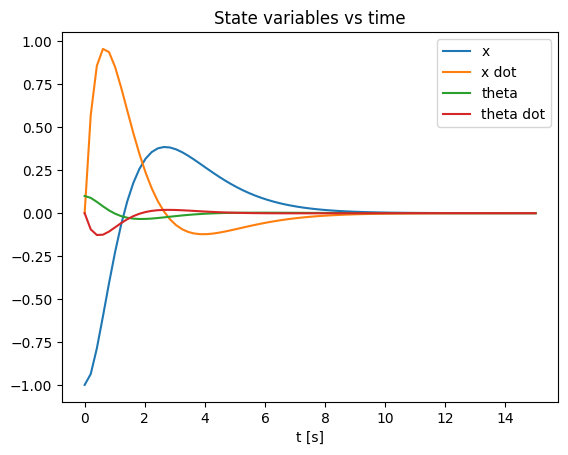

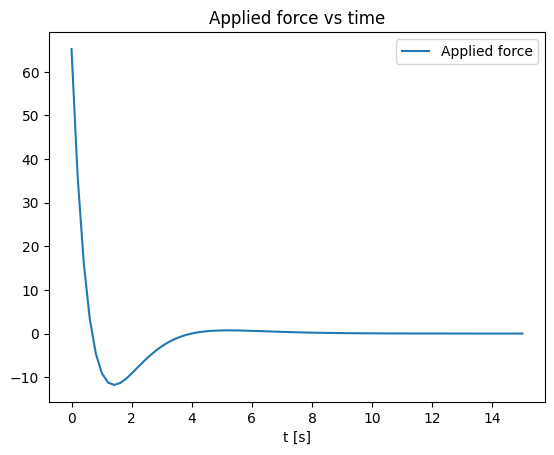

In [27]:
plot_state_vector_vs_time(t, X)
plot_input_vs_time(t, U)

### 2.1 Apply a Linear Quadratic Regulator with infinite time horizons to solve the controls problem
In the previous section, we showed that we can create a stable system by setting arbitrary negative eigenvalues for the matrix $A - BK$. However, what are the optimal eigenvalues? There is an apparent trade between stability and energy used for control. 

The Linear Quadratic Regulators (LQR) allows us to find an optimal eigenvalues by minimizing the quadratic cost function: 

$$
J(t) = \int_0^\infty (x^T Q x + u^T R u) dt
$$

where $q_1$, $q_2$, $q_3$, $q_4$, and $r$ are non-negative weights 

$$
\mathbf{Q} = \begin{bmatrix} q_1 & 0 & 0 & 0 \\ 0 & q_2 & 0 & 0 \\ 0 & 0 & q_3 & 0 \\ 0 & 0 & 0 & q_4 \end{bmatrix}

\mathbf{R} = [r]
$$

Basically, large values for $q1$, $q2$, $q3$, and $q4$ penalize instability in each of the four state variables while a large $r$ penalizes significant summed control force. 

To minimize the cost function, we need a K that satisfies

$$
K = - R^{-1} (B^TP)
$$

Where P is found by solving the [algebraic Riccati equation](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation).

$$
\dot{P}(t) = P A + A^T P + Q - PBR^{-1} B^T P 
$$

A derivation of Riccati's equation can be found [here](https://databookuw.com/databook.pdf#page=365). Because this problem has infinite time horizons, $\dot{P} = 0$. $P$ therefore is a constant matrix that satisfies:

$$
P A + A^TP + Q - PBR^{-1} B^T P = 0
$$

The evolution of the optimal state vector $\tilde{x}$ can then be described. 
$$
\dot{\tilde{x}} = (A - B K)\tilde{x}
$$

### 2.2 Code
The code to solve the LQR optimization problem is pretty simple because I used the python scipy function `scipy.linalg.solve_continuous_are`.

In [28]:
def get_matrices_Q_R(q1, q2, q3, q4, r):
    """
    Returns cost matrices Q and R that effectively place a weight on 
    the cost of errors in the state vector (q1, q2, q3, q4) and the cost
    of non-zero control impulse (r). 

    Parameters:
    q1 (float): relative weight of position of cart.
    q2 (float): relative weight of velocity of cart. 
    q3 (float): relative weight of displacement theta of pole.
    q4 (float): relative weight of angular velocity of pole. 
    r (float): relative weight of control force. 

    Returns:
    R (numpy.ndarray): weights of control vars.
    Q (numpy.ndarray): weights of system vars. 
    """

    R = np.array([r])

    Q = np.array([
        [q1, 0, 0, 0],
        [0, q2, 0, 0],
        [0, 0, q3, 0],
        [0, 0, 0, q4]
    ])

    return Q, R

def J(t, Q, R, X, U):
    cost = 0

    for i in range(len(t)):
        cost += X[i].T @ Q @ X[i] + U[i] * R * U[i]
    
    return cost


def find_K_lqr(A, B, Q, R):
    """
    Return the matrix P, which satisfies the Riccati differential equation.

    Parameters:
    -----------
    A (numpy.ndarray): System matrix (4,4).
    B (numpy.ndarray): Input matrix (4,1).
    Q (numpy.ndarray): Weights of system vars (4, 4).
    R (numpy.ndarray): Weights of control vars (1, 1). 

    Returns
    -------
    K           : the matrix solution of the Riccati equation. 
    """
    
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    return 1/R * B.T @ P

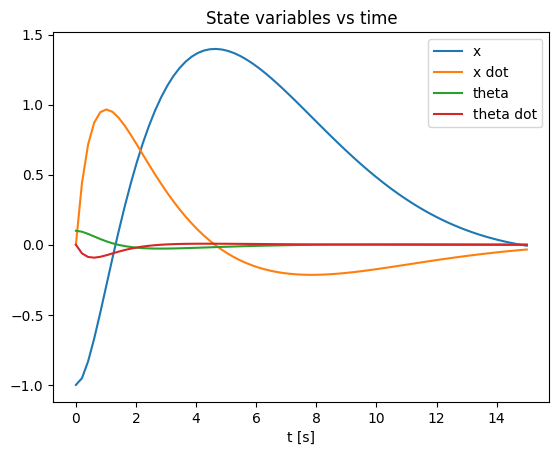

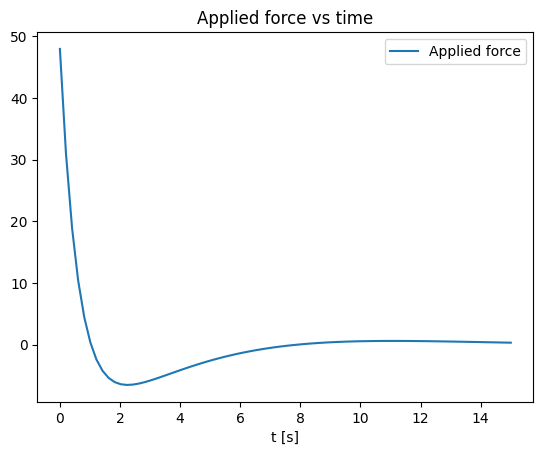

In [30]:
q1, q2, q3, q4 = 1, 1, 1, 1
r = 0.2

Q, R = get_matrices_Q_R(q1, q2, q3, q4, r)

K = find_K_lqr(A, B, Q, R)

X, U = solve_cart_control(t, X0, K, dxdt_wrapper)

plot_state_vector_vs_time(t, X)
plot_input_vs_time(t, U)

HTML(animate_cart_and_pendulum(t, X).to_html5_video())

In the above example, we can see that by adding a penalty on $F$ the convergence occurs much more slowly. Experimenting with different values for $q1$, $q2$, $q3$, and $q4$ I am able to tune the responsiveness of the controller. 

Here is a diagram of our current setup from the [same textbook I referenced above](https://databookuw.com/databook.pdf#page=344).

<img src="./NoMeasurmentUncertainty.png" width="400"/>

## 3. State estimation with a Kalman Filter

Prior to this point, I have been assuming that I have access to the full true state $X$. In a real world system, a more accurate model would be this one:

$$
\begin{align}
\dot{x} &= Ax + Bu + \omega_d \\
y &= Cx + \omega_n
\end{align}
$$

where $y$ is the measurement, $\omega_d$ is a gaussian disturbance to the state and $\omega_n$ is sensor noise. I will assume we are aware of the covariance matrices $\Nu_d$ and $\Nu_n$ of gaussian noises. The true state $x$ is now subject to some unknown disturbance.  

An estimate $\hat{x}$ for $x$ can be found  by the following dynamics: 

$$
\begin{align}
\dot{\hat{x}} &= A \hat{x} + Bu + K_f (y - \hat{y}) \\

\hat{y} &= C \hat{x} 
\end{align}
$$

$A$, $B$, $C$ are determined from the system model. $K_f$ is the Kalman gain.


The above equations simplify to 

$$
\begin{align}
\dot{\hat{x}} &= A \hat{x} + B u + K_f (y - C \hat{x}) \\
\dot{\hat{x}} &= (A - K_f C) \hat{x} + B u + K_f y \\
\end{align}
$$

The author of the textbook points out that when the system is fully observable (see section below), the state estimate $\hat{x}$ converges to $x$ provided the linear model is an accurate representation of the system.

$$
\begin{align}
\dot{\epsilon} &= \dot{x} - \dot{\hat{x}} \\
&= [Ax + Bu + \omega_d] - [(A - K_f C)\hat{x} + K_f y + Bu] \\
&= A \epsilon + \omega_d + K_f C \hat{x} - K_f y \\
&= A \epsilon + \omega_d + K_f C \hat{x} - K_f [Cx + \omega_n] \\
&= (A - K_f C) \epsilon + \omega_d - K_f \omega_n

\end{align}
$$

From this, we can see that $\epsilon$ converges, so long as the eigenvalues of $A - K_f C$ are negative. And so long as the system is fully observable, we can set the eigenvalues of $A - K_f C$ by selecting the appropriated matrix for $K_f$. 


## 3.1 Observability 

Per my favorite textbook, "A system is observable if it is possible to estimate any state $\epsilon \in \R^n$ from a time history of measurements."

The observability, is defined be the row space of the matrix:

$$
O = \begin{bmatrix} C \\ C A \\ CA^2 \\ .. \\ CA^{n-1} \end{bmatrix}
$$

In [31]:
# Define C where we only observe x1
C = np.array([1, 0, 0, 0]).reshape(1,4)

print(f"If we can observe only x1 at all time steps, then the system is fully observable as the rank of the observability matrix is {np.linalg.matrix_rank(control.obsv(A, C))}.")

If we can observe only x1 at all time steps, then the system is fully observable as the rank of the observability matrix is 4.


## 3.3 Code
First, lets calculate the Kalman gain using the LQR method we used to calculate the proportional response matrix above.

In [32]:
Vd = np.eye(4) # disturbance covariance 
Vn = 1 # measurement noise covariance

Kf = control.lqr(A.T, C.T, Vd, Vn)[0].T

print(f"A shape {A.shape}")
print(f"C shape {C.shape}")
print(f"Kf shape {Kf.shape}")

print(f"The eigenvalues of A - Kf C : {np.linalg.eig(A - Kf @ C)[0]}")

A shape (4, 4)
C shape (1, 4)
Kf shape (4, 1)
The eigenvalues of A - Kf C : [-0.9125859 +0.54543615j -0.9125859 -0.54543615j -1.82557088+0.j
 -1.43983912+0.j        ]


Next, lets write functions to return $\omega$ and the linearized differential equation for the observed state derivate. Basically that derivative will combine the current estimate with the new measurement. The new measurement will be weighted by $K_f$, which is a function of the uncertainty of the measurement. In our example, we assume that every measurement has the same uncertainty. 

In [82]:
def get_noise(Vd, Vn, seed=None):
    """ 
    Returns a 5 by 1 matrix of normal distributed random numbers 
    based on the covariance matrix Vd and the scalar variance Vn.as_integer_ratio

    Parameters:
    Vd (numpy.ndarray): Covariance matrix (4, 4).
    Vn (float): Variance.

    Returns:
    omega (numpy.ndarray): Gaussian noise (5, 1).

    """
    if seed:
        np.random.seed(seed)

    omega_d = np.random.multivariate_normal(np.zeros(4), Vd)
    omega_n = np.random.normal(0, Vn)

    omega = np.zeros(5)
    omega[0:4] = omega_d
    omega[4] = omega_n

    return omega.reshape(5,1)

def dxhatdt(_, x_hat, u, y):
    """
    Returns the linearized derivative for xhat.

    Parameters:
    x_hat (numpy.ndarray): estimate of x, (4, 1)
    u (numpy.ndarray): control input (1, )
    y (numpy.ndarray): measurement (1, )

    Return
    dxhatdt (numpy.ndarray): estimate of dx/dt (4).
    
    """

    dxhatdt = (A - Kf @ C) @ x_hat + B @ u + Kf @ y
    
    return dxhatdt.reshape(4)

def dxdt_linear_wrapper(_, x, u, omega=np.zeros((4,1))):
    """Wrapper of the previously defined linearized derivative which listed parameters in a different order."""

    return dxdt_linear(x, _, u, omega)

def dxdt_nonlinear_wrapper(_, x, u, omega=np.zeros(4)):
    """Wrapper of the previously defined non-linear derivative which listed parameters in a different order."""

    return dxdt_nonlinear(x, _, u, omega)


In [136]:
import copy

def run_cart_sim(seed=0):
    """Function that iterates over each time step and returns the true state, the state with noise, the estimated state, the measurement, the control input, and the noise. """
    
    X_true = np.zeros((len(X0), len(t)))
    X_true[:, 0] = X0
    X_est = copy.deepcopy(X_true)
    
    y = np.zeros((len(t),1))
    u = np.zeros((len(t), 1))
    omegas = np.zeros((len(t), 5))
    dt = t[1]-t[0]
    y[0] = C @ X0

    for i in np.arange(len(t)-1):
        omega = get_noise(Vd*0.1, Vn*0.1, seed=i+seed)
        
        u_est = -Kr @ X_est[:, i]
        
        dxdt_est = dxhatdt(t[i], X_est[:, i], u_est, y[i])

        # The fundamental truth model introduces some disturbance noise at each time step. 
        dxdt_true = dxdt_nonlinear_wrapper(t[i], X_true[:, i], u_est, omega[0:4])
        
        X_est[:, i+1] = X_est[:, i] + dxdt_est * dt
        X_true[:, i+1] = X_true[:, i] + dxdt_true * dt

        y[i+1] = C @ X_true[:, i+1] + omega[4]
        u[i] = u_est
        omegas[i] = omega.reshape(5)
    

    return X_true , X_est, y, u, omegas

In [65]:
def plot_true_and_estimated_data(X_true, X_est, y, t):
    """Plot the true, true with noise, and estimated data of each state variable."""
    
    plt.title("Cart position")
    plt.plot(t, y, label="measured")
    plt.plot(t, X_true[0,:], label="True")
    plt.plot(t, X_est[0,:], label="Est")
    plt.ylabel("position [m]")
    plt.xlabel("time [s]")
    plt.legend()
    plt.show()

    plt.title("Cart velocity")
    plt.plot(t, X_true[1,:], label="True")
    plt.plot(t, X_est[1,:], label="Est")
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.legend()
    plt.show()

    plt.title("Pendulum angle")
    plt.plot(np.arange(X_true.shape[1]), X_true[2,:], label="True")
    plt.plot(np.arange(X_true.shape[1]), X_est[2,:], label="Est")
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.legend()
    plt.show()

    plt.title("Pendulum angular velocity")
    plt.plot(np.arange(X_true.shape[1]), X_true[3,:], label="True")
    plt.plot(np.arange(X_true.shape[1]), X_est[3,:], label="Est")
    plt.xlabel("time [s]")
    plt.ylabel("angular velocity [rad/s]")
    plt.legend()
    plt.show()

### 3.4 Example with large state uncertainty

Let's first see how the Kalman filter does with reasonable large disturbance noise and measurement noise. We can see in the below graphs that the Kalman filter does a reasonably good job smoothing out the noise, but that the cart-pendulum system never converges. The error terms are sufficiently large that the control law is unable to stabilize the pendulum.

In the below simulation, our control cycle runs at a frequency of 200Hz. 

In this high noise regime, the true and estimate states eventually diverge. This likely occurs because I am using nonlinear system of equations to model the true state, but linear equations to model the estimated state. Once $\theta$ deviates very far from 0, the linearized kinematics model ceases to be a an accurate representation. Once the true state diverges slightly from the estimated state, the control law based on the estimated state is no longer the correct control for the true state. 


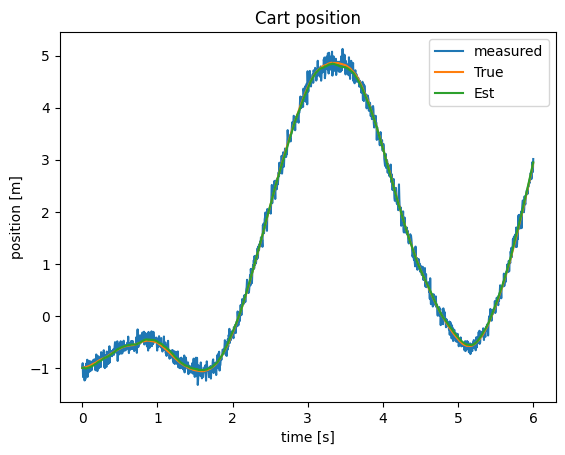

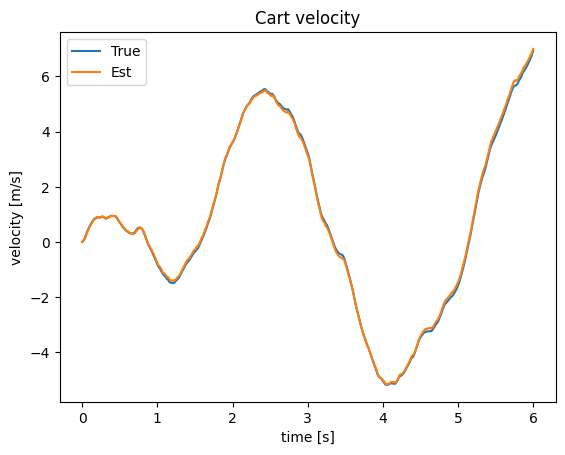

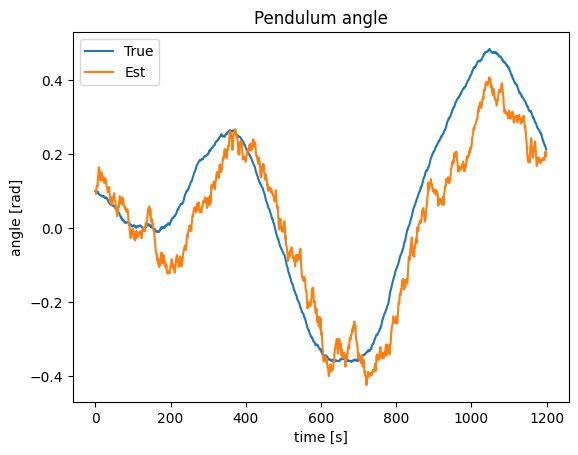

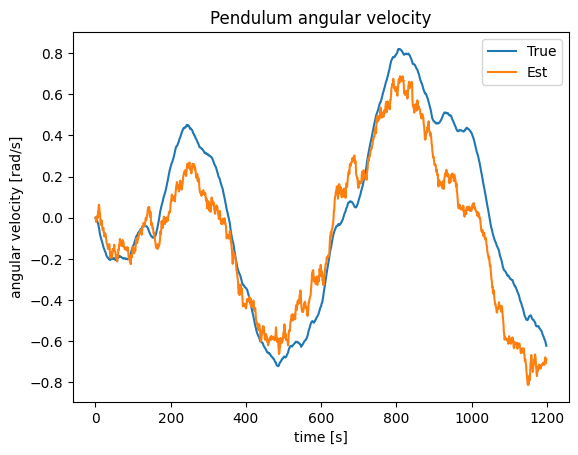

In [148]:
Vd = np.eye(4) # disturbance covariance 
Vn = 1 # measurement noise covariance

Kf = control.lqr(A.T, C.T, Vd, Vn)[0].T

t = np.linspace(0, 6, 1200)

X_true, X_est, y, u, omegas = run_cart_sim(seed=1)

plot_true_and_estimated_data(X_true, X_est, y, t)

### 3.5 Example with smaller state uncertainty
In order to converge, we need to reduce the measurement uncertainty by about a factor of 1000 while still running the control cycle at a 100Hz frequency. We then see that the control law is able to stabilize the pendulum with a state estimation based entirely on noisy data. 

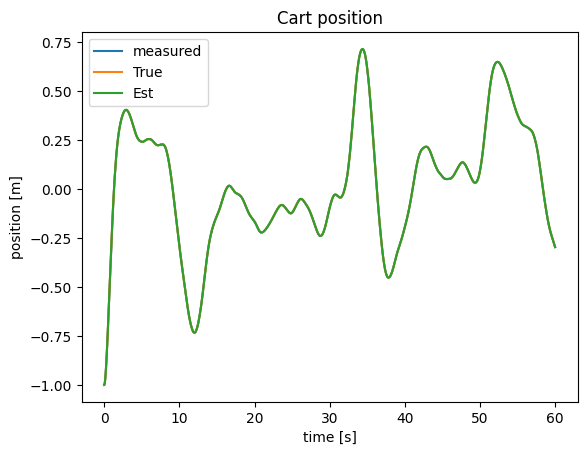

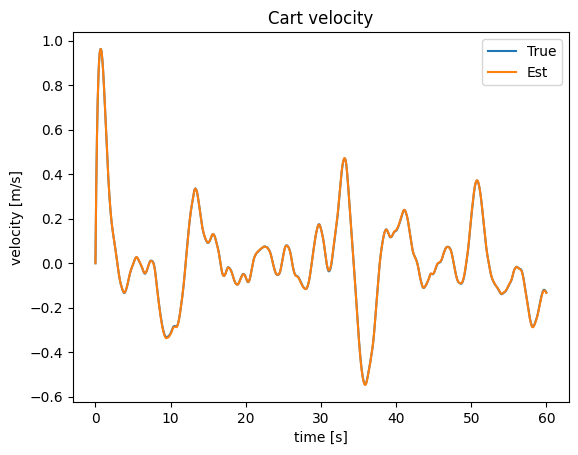

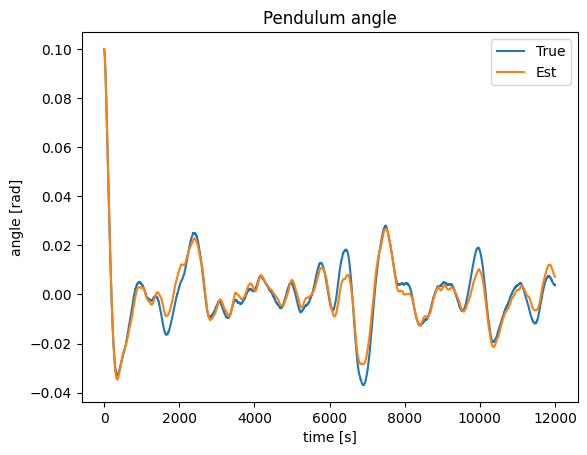

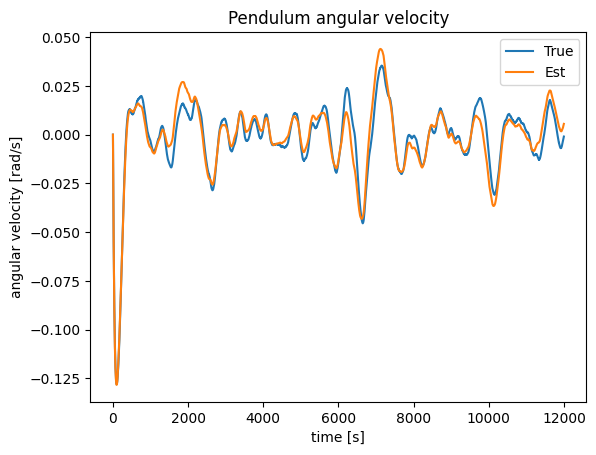

In [146]:
Vd = np.eye(4) * 0.0005 # disturbance covariance 
Vn = 0.001 # measurement noise covariance

Kf = control.lqr(A.T, C.T, Vd, Vn)[0].T

t = np.linspace(0, 60, 12000)

X_true, X_est, y, u, omegas = run_cart_sim()

plot_true_and_estimated_data(X_true, X_est, y, t)


## 4. Conclusion

The inverted pendulum was a valuable problem to work on because it is reasonably simple and allowed me to review the kinematics, control, and state estimation. If I have additional time in the future, one extension of this project would be to analyze the control law in the frequency domain. 